In [1]:
import numpy as np
import random
from numpy.random import default_rng
import warnings
import math
from scipy.stats import norm, multivariate_normal
from scipy import integrate
import scipy.optimize as optimize
import os
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel, DotProduct
from sklearn.preprocessing import StandardScaler, PowerTransformer
from scipy.stats import qmc
import pandas as pd
from enum import Enum
import scipy
import matplotlib.pyplot as plt

import itertools
from itertools import combinations_with_replacement
from itertools import combinations
from itertools import permutations

In [2]:
def model(params, x, args = None):
    """
    Calculates the value of y for case study 1
    
    Parameters
    ----------
    params: ndarray, The array containing the true values of Theta1 and Theta2
    x: ndarray, The list of xs that will be used to generate y
    args: dict, extra arguments to pass to the function. Default None
    
    Returns
    --------
    y_poly: ndarray, The noiseless values of y given theta_true and x
    """
    t1, t2 = params
    y_poly =  t1*x + t2*x**2 +x**3
    
    return y_poly

def lhs_sampling(num_points, bounds, seed):
    """
    Design LHS Samples

    Parameters
    ----------
    num_points: int, number of points in LHS, should be greater than # of dimensions
    bounds: ndarray, array containing upper and lower bounds of elements in LHS sample. Defaults of 0 and 1
    seed: int, seed of random generation

    Returns
    -------
    lhs_data: ndarray, array of LHS sampling points with length (num_points) 
    """
    #Define number of dimensions
    dimensions = bounds.shape[1]
    #Define sampler
    sampler = qmc.LatinHypercube(d=dimensions, seed = seed)
    lhs_data = sampler.random(n=num_points)

    #Generate LHS data given bounds
    lhs_data = qmc.scale(lhs_data, bounds[0], bounds[1]) #Using this because I like that bounds can be different shapes

    return lhs_data

def grid_sampling(num_points, bounds):
        """
        Generates Grid sampled data
        
        Parameters
        ----------
        num_points: int, number of points in LHS, should be greater than # of dimensions
        bounds: ndarray, array containing upper and lower bounds of elements in LHS sample. Defaults of 0 and 1
        
        Returns:
        ----------
        grid_data: ndarray, (num_points)**bounds.shape[1] grid sample of data
        
        """
        #Generate mesh_grid data for theta_set in 2D
        #Define linspace for theta
        params = np.linspace(0,1, num_points)
        #Define dimensions of parameter
        dimensions = bounds.shape[1]
        #Generate the equivalent of all meshgrid points
        df = pd.DataFrame(list(itertools.product(params, repeat=dimensions)))
        df2 = df.drop_duplicates()
        scaled_data = df2.to_numpy()
        #Normalize to bounds 
        lower_bound = bounds[0]
        upper_bound = bounds[1]
        grid_data = scaled_data*(upper_bound - lower_bound) + lower_bound 
        return grid_data

1**2 * Matern(length_scale=3.1, nu=2.5) + WhiteKernel(noise_level=0.0001)


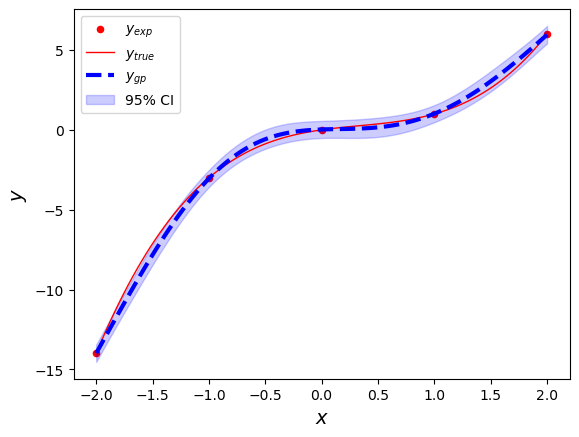

In [3]:
#Set problem parameters
# np.random.seed(int(1))
noise_std = 0.01

#Set specific example parameters
num_points_x = 5
bounds_x = np.array([[-2],[2]])
bounds_theta_l = [-2, -2]
bounds_theta_u = [ 2,  2]
bounds_theta= np.array([bounds_theta_l, bounds_theta_u])
theta_ref = np.array([1.0, -1.0]) 

#Create Experimental Data
Xexp = grid_sampling(num_points_x, bounds_x).reshape(-1,1)
Yexp = model(theta_ref, Xexp)
noise = np.random.normal(size=Yexp.shape, loc = 0, scale = noise_std)
Yexp = Yexp + noise

#Create training data
num_points_theta = 20
train_theta_org = lhs_sampling(num_points_theta, bounds_theta, 1)
train_theta = np.repeat(train_theta_org, len(Xexp) , axis = 0)
train_x = np.vstack([Xexp]*num_points_theta)
train_data = np.concatenate((train_theta, train_x), axis=1)
train_y = np.array([model(theta[:-1], theta[-1]) for theta in train_data]).flatten()

#Set GP Model
noise_kern = WhiteKernel(noise_level = noise_std**2, noise_level_bounds= "fixed") #bounds = "fixed"
c_kern = ConstantKernel(constant_value= 1, constant_value_bounds = "fixed")
Mat_kern = Matern(length_scale = 1, length_scale_bounds=(1e-3, 1e3), nu=2.5)
kernel = c_kern*Mat_kern + noise_kern
gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, normalize_y = True)

#Scale x and fit model
fit_gp_model = gp_model.fit(train_data, train_y)

print(fit_gp_model.kernel_)

#Check that GP works
#Generate t guess and t_matrix
t_matrix = np.array([[0,1,0,0,0],[0,0,0,1,0]])
theta_guess = np.array([0,1,0,-1,0]).reshape(1,-1)

#Create Sim data for comparison
X = grid_sampling(100, bounds_x)
Y = model(theta_ref, X)

#Get gp predictions
gp_theta_org = theta_guess@t_matrix.T
gp_theta = np.repeat(gp_theta_org, len(X) , axis = 0)
gp_input = np.concatenate((gp_theta, X), axis=1)
gp_mean, gp_covar = fit_gp_model.predict(gp_input, return_cov=True)
gp_std = np.sqrt(np.diag(gp_covar))

#Plot data for visualization
plt.scatter(Xexp,Yexp, color = "r", s=20,label=r"$y_{exp}$")
plt.plot(X,Y,'r-',linewidth=1,label=r"$y_{true}$")
plt.plot(X,gp_mean,'b',linestyle = "--",label=r"$y_{gp}$", linewidth = 3)
plt.fill_between(X.flatten(), gp_mean-2*gp_std, gp_mean+2*gp_std, alpha=0.2, color = "b", label = "95% CI")
# plt.title(r"all trained")
plt.xlabel(r"$x$",fontsize=14)
plt.ylabel(r'$y$',fontsize=14)
plt.legend()
plt.show()


1**2 * Matern(length_scale=5.69, nu=2.5) + WhiteKernel(noise_level=0.0001)


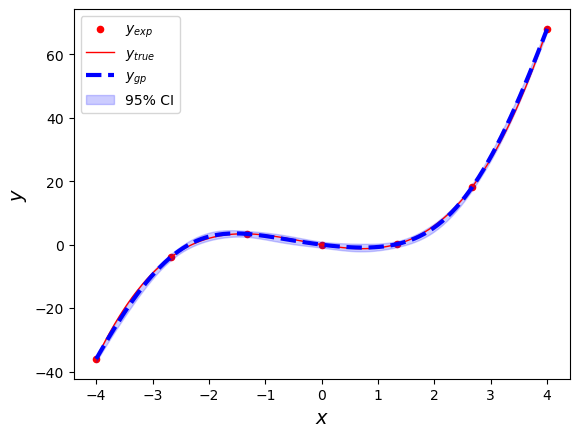

In [4]:
#Create 2nd gp for an example
#Set problem specific stuff
num_points_x2 = 7
bounds_x2 = np.array([[-4],[4]])
bounds_theta_l2 = [-4, 0]
bounds_theta_u2 = [ 0,  4]
bounds_theta2= np.array([bounds_theta_l2, bounds_theta_u2])
theta_ref2 = np.array([-3.0, 1.0]) 

#Create Experimental Data
Xexp2 = grid_sampling(num_points_x2, bounds_x2).reshape(-1,1)
Yexp2 = model(theta_ref2, Xexp2)
noise2 = np.random.normal(size=Yexp2.shape, loc = 0, scale = noise_std)
Yexp2 = Yexp2 + noise2

#Create training data
train_theta_org2 = lhs_sampling(num_points_theta, bounds_theta2, 1)
train_theta2 = np.repeat(train_theta_org2, len(Xexp2) , axis = 0)
train_x2 = np.vstack([Xexp2]*num_points_theta)
train_data2 = np.concatenate((train_theta2, train_x2), axis=1)
train_y2 = np.array([model(theta[:-1], theta[-1]) for theta in train_data2]).flatten()

#Set GP Model
kernel2 = c_kern*Mat_kern + noise_kern
gp_model2 = GaussianProcessRegressor(kernel=kernel2, n_restarts_optimizer=50, normalize_y = True)

#Scale x and fit model
fit_gp_model2 = gp_model2.fit(train_data2, train_y2)

print(fit_gp_model2.kernel_)

#Check that GP works

#Generate t guess and t_matrix
t_matrix2 = np.array([[0,0,1,0,0],[0,0,0,0,1]])
theta_guess2 = np.array([0,0,-3.0,0,1.0]).reshape(1,-1)

#Create Sim data for comparison
X2 = grid_sampling(100, bounds_x2)
Y2 = model(theta_ref2, X2)

#Get gp predictions
gp_theta_org2 = theta_guess2@t_matrix2.T
gp_theta2 = np.repeat(gp_theta_org2, len(X2) , axis = 0)
gp_input2 = np.concatenate((gp_theta2, X2), axis=1)
gp_mean2, gp_covar2 = fit_gp_model2.predict(gp_input2, return_cov=True)
gp_std2 = np.sqrt(np.diag(gp_covar2))

#Plot data for visualization
plt.scatter(Xexp2,Yexp2, color = "r", s=20,label=r"$y_{exp}$")
plt.plot(X2,Y2,'r-',linewidth=1,label=r"$y_{true}$")
plt.plot(X2,gp_mean2,'b',linestyle = "--",label=r"$y_{gp}$", linewidth = 3)
plt.fill_between(X2.flatten(), gp_mean2-2*gp_std2, gp_mean2+2*gp_std2, alpha=0.2, color = "b", label = "95% CI")
# plt.title(r"all trained")
plt.xlabel(r"$x$",fontsize=14)
plt.ylabel(r'$y$',fontsize=14)
plt.legend()
plt.show()


In [5]:
#To scale objective function to multiple GPs...
#Create fxn for analyzing a single gp
def eval_gp_new_theta(theta_guess, t_matrix, gp_object, Xexp):
    #Get theta into correct form using t_matrix
    theta_guess = theta_guess.reshape(1,-1)
    gp_theta = theta_guess@t_matrix.T
    #Append x data for consideration
    gp_theta = np.repeat(gp_theta, len(Xexp) , axis = 0)
    gp_input = np.concatenate((gp_theta, Xexp), axis=1)
    #Get mean and std from gp
    gp_mean, gp_covar = gp_object.predict(gp_input, return_cov=True)
    gp_std = np.sqrt(np.diag(gp_covar))
    
    return gp_mean, gp_std

#define the scipy function for minimizing
def scipy_min_fxn(theta_guess, t_matricies, gps, Xexp_list, Yexp_list):
    #Assert you have data and a transformation matrix for each gp
    assert len(t_matricies) == len(gps) == len(Xexp_list) == len(Yexp_list), "lists must be the same length"
    #Initialize weight and squared error arrays
    sqerr_array  = []
    weight_array = []
    #loop over number of gps (since there is one gp for every molecule and property)
    for i in range(len(gps)):
        #Evaluate GP
        gp_mean, gp_std = eval_gp_new_theta(theta_guess, t_matricies[i], gps[i], Xexp_list[i])
        #Calculate weight from uncertainty
        weight_mpi = (1/(gp_std**2)).tolist()
        weight_array += weight_mpi
        #Calculate sse
        sq_err = ((Yexp_list[i].flatten() - gp_mean)**2).tolist()
        sqerr_array += sq_err
    #List to array
    sqerr_array = np.array(sqerr_array)
    weight_array = np.array(weight_array)
    #Normalize weights to add up to 1
    scaled_weights = weight_array / np.sum(weight_array)
    #Define objective function
    obj = np.sum(scaled_weights*sqerr_array)
    return obj

In [6]:
## specify initial guesses bounds for new_theta
repeats = 50
bounds_theta_new_l = [-5, -5, -5, -5, -5]
bounds_theta_new_u = [ 2,  2,  2,  2,  2]
bounds_theta_new = np.array([bounds_theta_new_l, bounds_theta_new_u]).T
theta_guesses = np.random.uniform(low=bounds_theta_new_l, high=bounds_theta_new_u, size=(repeats, len(bounds_theta_new_l)) )

#Define matricies, gps, and data to look at
t_matricies = [t_matrix, t_matrix2]
gps = [fit_gp_model, fit_gp_model2]
Xexp_list = [Xexp, Xexp2]
Yexp_list = [Yexp, Yexp2]

#Intialize data storage matricies
theta_vals = np.zeros((repeats, len(bounds_theta_new_l)))
l2_norms = np.zeros(repeats)
costs = np.zeros(repeats)
fxn_evals = np.zeros(repeats)

#Optimize w/ retstarts
for i in range(repeats):
    #Get guess and find scipy.optimize solution
    t_guess = theta_guesses[i]
    Solution = optimize.minimize(scipy_min_fxn, t_guess , bounds=bounds_theta_new, method='L-BFGS-B', args=(t_matricies, gps, Xexp_list, Yexp_list), 
                                 options = {"disp":True})
    #Back out results
    theta_min_obj = Solution.x
    costs[i] = Solution.fun
    theta_vals[i] = theta_min_obj
    #Note counting Jacobian and function evalauations as function evaluations
    fxn_evals[i] = Solution.nfev + Solution.njev
    
#Print Results
nlr_theta = theta_vals[np.argmin(costs)]
nlr_l2_norm = l2_norms[np.argmin(costs)]
nlr_evals = fxn_evals[np.argmin(costs)]
print("GP New Theta", nlr_theta)
print("GP Theta 1 = ", nlr_theta@t_matrix.T)
print("GP Theta 2 = ", nlr_theta@t_matrix2.T)
print("Evaluations = ", nlr_evals)
print("Func Val", costs[np.argmin(costs)])

GP New Theta [-1.32167233  1.00344116 -2.99909155 -0.99545842  0.99952895]
GP Theta 1 =  [ 1.00344116 -0.99545842]
GP Theta 2 =  [-2.99909155  0.99952895]
Evaluations =  126.0
Func Val 0.0008179788700642491
